# _Predicting NHL Player Info_

One of my favorite sports to watch is hockey. I found a [hockey dataset](https://www.kaggle.com/martinellis/nhl-game-data/version/1#game_plays.csv) on Kaggle that looks kinda fun. Let's check it out.

**Goal:** The datasets from Kaggle provides basic player stats (# goals scored, assists, time on ice, etc.). I will build a couple models that make predictions about the player based only on his stats.

**Initial predictions**: A player's statistics can be indicative of his age and his position.

**How to Follow:** Read it like an article. Start at the top, read each text block and follow the story. Don't worry about what the code is saying.  

## Project Summary

### Part 1. Loading the Data:
* Loading and combining all the datasets into one dataframe called `players`.

### Part 2. Exploratory Data Analysis:
* Looking for features to select from `players` dataset that will help us predict player's age.

### Part 3. Test Train Split & Feature Selection:
* Splitting the data into testing and training set. The training data is used to train the model and the test data is used to see how accurate our model predictions are.

### Part 4. Building a Linear Regression Model:
* Selecting `mean squared error` as my error metric. I then construct a linear regression model that predicts a player's age.

### Part 5. Multiclass Classification:
* Using player statistics to predict player positions.

### Conclusion:
* I found that player stats do have some indication of a player's age and position. Predicting player age is affected by major outliers as we see with the `Radek Martinek` case, and predicting player position is a bit more accurate.

In [32]:
# Imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge, LogisticRegression
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
sns.set(style="whitegrid", palette="muted")
%matplotlib inline

## 1. Loading the Data

The csv files I will be using are defined below which are stored in the `hockey` directory:
* **game.csv**  
* **player_info.csv**
* **team_info.csv**
* **game_plays_players.csv**

In [33]:
game = pd.read_csv('hockey/game.csv')
player_info = pd.read_csv('hockey/player_info.csv')
team_info = pd.read_csv('hockey/team_info.csv')
game_plays = pd.read_csv('hockey/game_plays_players.csv')
skater_stats = pd.read_csv('hockey/game_skater_stats.csv')

There are multiple datasets that contain information about `player_id`. Below, I combine the ones I think will be useful. I also do a little bit of cleaning.

In [34]:
# Merging player datasets
players = skater_stats.groupby('player_id').sum()
players = players.loc[:, ['shots', 'goals', 'assists', 'hits', 'timeOnIce', 
                          'faceOffWins', 'penaltyMinutes', 'faceoffTaken',
                         'powerPlayGoals', 'takeaways', 'giveaways']]
# Renaming some columns
players = players.merge(player_info, how='left', on='player_id')
players = players.rename(columns={'primaryPosition':'pos', 'birthDate': 'dob', 'firstName': 'first',
                       'lastName':'last', 'powerPlayGoals': 'pp_goals', 'birthCity': 'cob',
                       'nationality': 'nat'})
# Make names lowercase
players['first'] = players['first'].str.lower()
players['last'] = players['last'].str.lower()

# Adding Time Columns
now = pd.Timestamp(datetime.now())
players['dob'] = pd.to_datetime(players['dob'])
players['dob'] = players['dob'].where(players['dob'] < now, players['dob'] -np.timedelta64(100, 'Y'))
players['age'] = (now - players['dob']).astype('<m8[Y]')
players.loc[:,'year'] = players['dob'].dt.year

Let's take a look at the distribution of ages in the NHL just so we have an idea about the data we're going to be working with. 

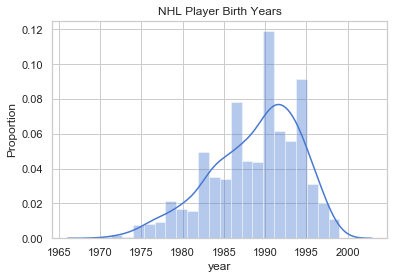

The average age in the NHL is 29.
The average birth year in the NHL is 1989.


In [35]:
current_year = 2018
mean = int(np.mean(players['year']).round())

sns.distplot(players['year'])
plt.title("NHL Player Birth Years")
plt.ylabel('Proportion')
plt.show()

print(f"The average age in the NHL is {current_year - mean}.")
print(f"The average birth year in the NHL is {mean}.")

## 2. Exploratory Data Analysis
First, let's look at the different columns we have to work with.

In [36]:
players.columns

Index(['player_id', 'shots', 'goals', 'assists', 'hits', 'timeOnIce',
       'faceOffWins', 'penaltyMinutes', 'faceoffTaken', 'pp_goals',
       'takeaways', 'giveaways', 'first', 'last', 'nat', 'cob', 'pos', 'dob',
       'link', 'age', 'year'],
      dtype='object')

Most of these features are numerical, which is good! Let's see if `age` has anything to do with the number of `goals` a player scores.

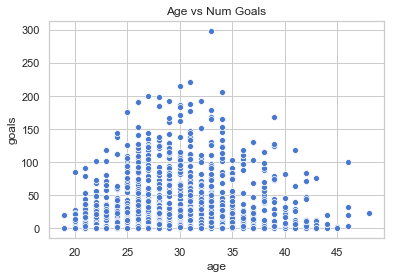

In [37]:
sns.scatterplot(x='age', y='goals', data=players)
plt.title('Age vs Num Goals')
plt.show()

At first glance, it appears that the distribution between age and the number of goals scored is normally distributed. Another feature we might want to look at is player position. Perhaps a player's `pos` might also be indicative of their age. See the plot below.

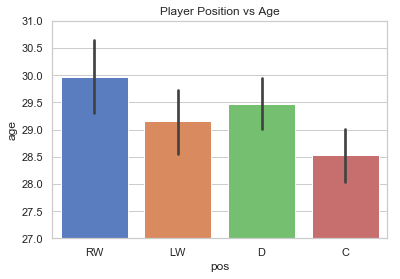

In [38]:
sns.barplot(x='pos', y='age', data=players)
plt.title("Player Position vs Age")
plt.ylim(27, 31)
plt.show()

It looks like player position might be a useful feature for our model.

# 3. Test Train Split & Feature Engineering

I will now split the data into a testing and training set. The training data will be used to train the model and the teting data will be used to see how well our model handles data it hasn't seen yet.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(players, players['age'], test_size=0.2, random_state=42)

Some of the features are categorical, so we need to do some [one-hot-encoding](https://en.wikipedia.org/wiki/One-hot) so we can add them to our feature matrix. The only categorical feature I use is a player's `position`.

In [40]:
# One-Hot-Encoding
position_train = pd.get_dummies(X_train['pos'], prefix='pos', prefix_sep='_')
position_test = pd.get_dummies(X_test['pos'], prefix='pos', prefix_sep='_')

train_pos = X_train['pos']
test_pos = X_test['pos']

# Dropping Features we Won't Need
train_df = X_train.drop(['year', 'age', 'link', 'dob', 'pos', 'cob', 'nat', 'last', 'first', 'player_id'], axis=1)
test_df = X_test.drop(['year', 'age', 'link', 'dob', 'pos', 'cob', 'nat', 'last', 'first', 'player_id'], axis=1)

# Final feature matrix
Train_Master = pd.concat([train_df, position_train ], axis=1)
Test_Master = pd.concat([test_df, position_test], axis=1)

print(Train_Master.shape)
print(Test_Master.shape)

(1264, 15)
(317, 15)


## 4. Building a Model
Now, the fun part! Let's make some predictions.

In [41]:
linear_model = lm.LinearRegression(fit_intercept=True)
linear_model.fit(Train_Master, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
pred_response = linear_model.predict(Train_Master)

I use the Mean Squared Error because I don't have any major outliers or negative values. This quantity is defined below:

$$
MSE =\frac{1}{n}\sum_{i}  ( y_i -\hat{y_i})^{2}
$$

In [43]:
def mse(actual, predicted):
    """
    Calculates MAE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the MAE
    """
    return np.mean((actual - predicted)**2)

In [44]:
train_error = mse(y_train, linear_model.predict(Train_Master))
test_error = mse(y_test, linear_model.predict(Test_Master))
print("Training error: ", train_error)
print("Testing error: ", test_error)

Training error:  27.2901033156
Testing error:  23.6358687931


The table below shows the `actual_age` and the `predicted_age` that my model generated from the testing data.

In [45]:
test_pred = linear_model.predict(Test_Master)

final = pd.DataFrame(data={
    'player_id': X_test['player_id'],
    'first': X_test['first'],
    'last': X_test['last'],
    'actual_age': X_test['age'],
    'predicted_age': test_pred.round()
})
final.head()

,player_id,first,last,actual_age,predicted_age
1124,8476805,spencer,abbott,30.0,29.0
813,8475246,kevin,connauton,28.0,29.0
1175,8476911,tanner,richard,25.0,28.0
534,8473584,andrew,macdonald,32.0,34.0
514,8473534,patrik,berglund,30.0,29.0


In [46]:
close = final[abs(final['actual_age'] - final['predicted_age']) <= 4]
accuracy = close.shape[0] / len(test_pred)
print("Test accuracy:", accuracy)

Test accuracy: 0.6561514195583596


As you can see above, several of the predictions appear to be pretty close, but we only have a 65% testing accuracy. This is because a few outliers are throwing off the accuracy.

In [47]:
final['difference'] = abs(final['actual_age'].astype(int) - final['predicted_age'].astype(int))
final.sort_values('difference', ascending=False).iloc[0,:]

player_id         8468101
first               radek
last             martinek
actual_age             42
predicted_age          28
difference             14
Name: 123, dtype: object

For `Radek Martinek`, my model predicted that he is 28 years old when he is actually 42 years old. That is a 14 year difference! 

Perhaps a player's statistics is not completely indicitive of his age. This is mainly because this type of analysis is subject to large outliers such as the `Radek Martinek` case.

**How to make our predictions more accurate?** To make my preditions more accurate, I would need more features merged from other datasets.

## 5. Multiclass Classification
Now, let's see if we can use the same statistics to predict what `position` each player is.

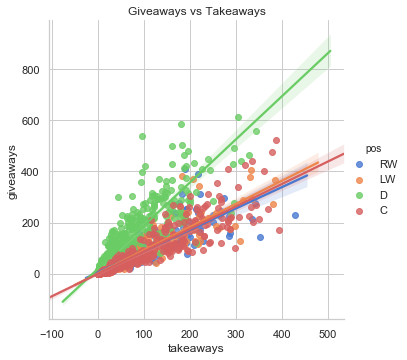

In [48]:
sns.lmplot(x='takeaways', y='giveaways', data=players, hue='pos')
plt.title("Giveaways vs Takeaways")
plt.show()

It definitely appears that there are some features from `players` that will help us determine what position a certain player is.

Below are the variables I will be reusing from part 3:
* **train_df** - training feature matrix without `pos`
* **test_df** - testing feature matrix without `pos`
* **train_pos** - player `positions` from the training data
* **test_pos** - player `positions` from the testing data

### Feature Selection
Here I remove the features that decrease the accuracy of my model. I determined which features to remove by running multiple tests and choosing the features that gave my model the highest accuracy.

In [49]:
train_df = train_df.drop(['penaltyMinutes', 'assists', 'shots'], axis=1)
test_df = test_df.drop(['penaltyMinutes', 'assists', 'shots'], axis=1)

Now, I define a logistic regression model. My model's predictions are stored in the `predicted_pos` column in the below dataframe.

In [50]:
# Defining a Logistic Regression model
lr = LogisticRegression(random_state=42)

# Fitting the model to the training data
lr.fit(train_df, train_pos)

# Storing my model's predictions from the test data
y_pred = lr.predict(test_df)

# RESULTS is the original testing data (not the feature matrix)
results = X_test.drop([ 'shots', 'goals', 'assists', 'hits', 'timeOnIce',
       'faceOffWins', 'penaltyMinutes', 'faceoffTaken', 'pp_goals',
       'takeaways', 'giveaways', 'nat', 'cob', 'dob',
       'link', 'age', 'year'], axis=1)

# Adding our predictions to RESULTS for comparison
results['predicted_pos'] = y_pred
results.head()

,player_id,first,last,pos,predicted_pos
1124,8476805,spencer,abbott,LW,LW
813,8475246,kevin,connauton,D,D
1175,8476911,tanner,richard,C,C
534,8473584,andrew,macdonald,D,D
514,8473534,patrik,berglund,C,C


In [51]:
# FINAL_2 is every player that my model accurately predicted their position
final_2 = results[results['pos'] == results['predicted_pos']]

test_accuracy = final_2.shape[0] / results.shape[0]
print('Test Accuracy: ', test_accuracy)

Test Accuracy:  0.750788643533123


My model accurately predicts a players `position` (only given their statistics) with a 75% accuracy. This isn't perfect, but it's much more accurate than predicting a player's age.